In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from zipfile import ZipFile

 #훈련 정상이미지 데이터 압축 풀기
#with ZipFile('/content/gdrive/MyDrive/두피 이미지/train/nomal/[원천]비듬_0.양호.zip') as zipper:
    #zipper.extractall('/content/gdrive/MyDrive/두피 이미지/train/nomal')

In [ ]:
 #훈련 비듬이미지 데이터 압축 풀기
#with ZipFile('/content/gdrive/MyDrive/두피 이미지/train/seborrhea/[원천]비듬_3.중증.zip') as zipper:
    #zipper.extractall('/content/gdrive/MyDrive/두피 이미지/train/seborrhea')

In [ ]:
 #검증 정상이미지 데이터 압축 풀기
#with ZipFile('/content/gdrive/MyDrive/두피 이미지/val/normal/[원천]비듬_0.양호.zip') as zipper:
   #zipper.extractall('/content/gdrive/MyDrive/두피 이미지/val/normal')

In [ ]:
 #검증 비듬이미지 데이터 압축 풀기
#with ZipFile('/content/gdrive/MyDrive/두피 이미지/val/seborrhea/[원천]비듬_3.중증.zip') as zipper:
    #zipper.extractall('/content/gdrive/MyDrive/두피 이미지/val/seborrhea')

In [ ]:
# 데이터 경로
data_path = "/content/gdrive/MyDrive/두피 이미지/"

# 훈련, 검증, 테스트 데이터 경로 설정
train_path = data_path + 'train/'
valid_path = data_path + 'val/'
test_path  = data_path + 'test/'

In [ ]:
#이미지 갯수

import os

normal_train = len(os.listdir('/content/gdrive/MyDrive/두피 이미지/train/normal'))
sebor_train = len(os.listdir('/content/gdrive/MyDrive/두피 이미지/train/seborrhea'))
normal_val = len(os.listdir('/content/gdrive/MyDrive/두피 이미지/val/normal'))
sebor_val = len(os.listdir('/content/gdrive/MyDrive/두피 이미지/val/seborrhea'))

print(f'훈련 정상데이터 개수: {normal_train}')
print(f'훈련 비듬데이터 개수: {sebor_train}')
print(f'검증 정상데이터 개수: {normal_val}')
print(f'검증 비듬데이터 개수: {sebor_val}')

훈련 정상데이터 개수: 534
훈련 비듬데이터 개수: 2256
검증 정상데이터 개수: 102
검증 비듬데이터 개수: 594


In [ ]:
from glob import glob

print(f'훈련 데이터 개수 : {len(glob(train_path + "*"))}')
print(f'검증 데이터 개수 : {len(glob(valid_path + "*/*"))}')

훈련 데이터 개수 : 2
검증 데이터 개수 : 696


In [ ]:
all_normal_imgs = []    # 모든 정상 이미지를 담을 리스트 초기화
all_seborrhea_imgs = [] # 모든 비듬 이미지를 담을 리스트 초기화


for cat in ['train/', 'val/']:
    data_cat_path = data_path + cat
    # 정상, 폐렴 이미지 경로
    normal_imgs = glob(data_cat_path + 'normal/*')
    seborrhea_imgs = glob(data_cat_path + 'seborrhea/*')
    # 정상, 폐렴 이미지 경로를 리스트에 추가
    all_normal_imgs.extend(normal_imgs)
    all_seborrhea_imgs.extend(seborrhea_imgs)

print(f'정상 두피 이미지 개수 : {len(all_normal_imgs)}')
print(f'비듬 두피 이미지 개수 : {len(all_seborrhea_imgs)}')

정상 두피 이미지 개수 : 636
비듬 두피 이미지 개수 : 2850


# 데이터 시각화

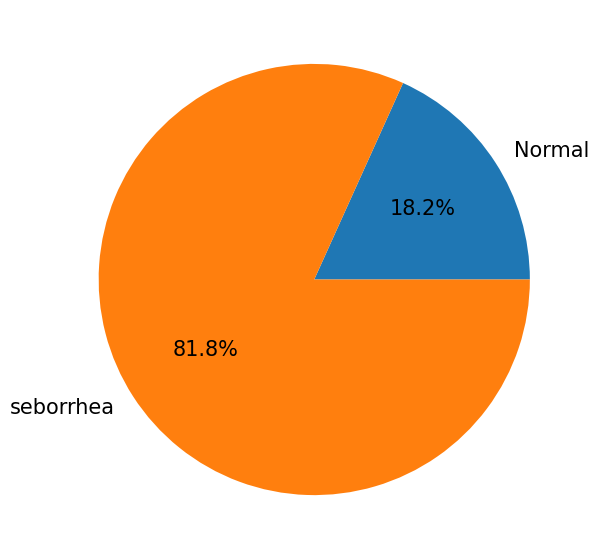

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Normal', 'seborrhea'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie([len(all_normal_imgs), len(all_seborrhea_imgs)],
        labels=label,
        autopct='%.1f%%');

- 타깃값은 정상 두피 데이터 19% 비듬 두피 데이터 81%로 분포한다

In [ ]:
import matplotlib.gridspec as gridspec
import cv2

def show_image(img_paths, rows=2, cols=3):
    assert len(img_paths) <= rows*cols # 이미지가 행/열 개수보다 많으면 오류 발생

    mpl.rc('font', size=8)
    plt.figure(figsize=(15, 8))
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치

    # 이미지 출력
    for idx, img_path in enumerate(img_paths):
        image = cv2.imread(img_path) # 이미지 파일 읽기
        ax = plt.subplot(grid[idx])
        ax.imshow(image) # 이미지 출력

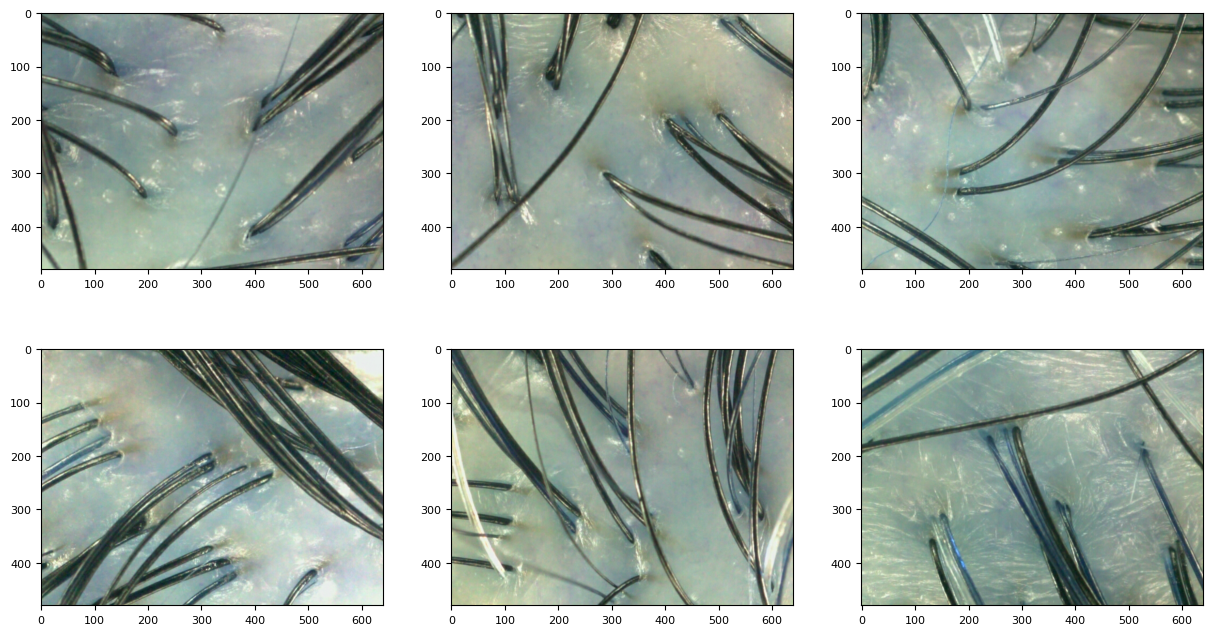

In [ ]:
# 정상 두피 이미지 경로(마지막 6장)
num_of_imgs = 6
normal_img_paths = all_normal_imgs[-num_of_imgs:]

# 이미지 출력
show_image(normal_img_paths)

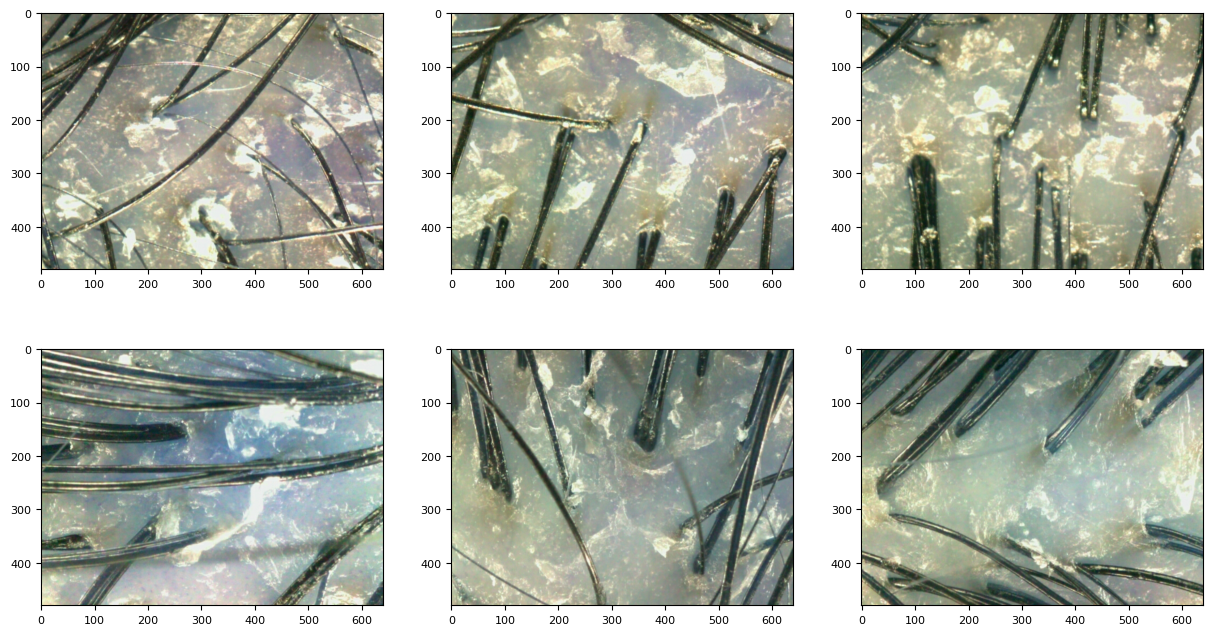

In [ ]:
# 비듬 두피 이미지 경로(마지막 6장)
seborrhea_img_paths = all_seborrhea_imgs[-num_of_imgs:]

# 이미지 출력
show_image(seborrhea_img_paths)

# 기본 모델링

In [ ]:
import torch # 파이토치
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from torchvision import transforms

# 훈련 데이터용 변환기
transform_train = transforms.Compose([
                          transforms.Resize((250, 250)),      # 이미지 크기 조정
                          transforms.CenterCrop(180),         # 중앙 이미지 확대
                          transforms.RandomHorizontalFlip(0.5), # 좌우 대칭
                          transforms.RandomVerticalFlip(0.2), # 상하 대칭
                          transforms.RandomRotation(20),      # 이미지 회전
                          transforms.ToTensor(),              # 텐서 객체로 변환
                          transforms.Normalize((0.485, 0.456, 0.406),
                                               (0.229, 0.224, 0.225))]) # 정규화

# 테스트 데이터용 변환기
transform_test = transforms.Compose([
                          transforms.Resize((250, 250)),
                          transforms.CenterCrop(180),
                          transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406),
                                               (0.229, 0.224, 0.225))])

In [ ]:
from torchvision.datasets import ImageFolder

# 훈련 데이터셋
datasets_train = ImageFolder(root='/content/gdrive/MyDrive/두피 이미지/train', transform=transform_train)
# 검증 데이터셋
datasets_valid = ImageFolder(root='/content/gdrive/MyDrive/두피 이미지/val' , transform=transform_test)

-  멀티 프로세싱 사용

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# 제너레이터 시드값 고정
g = torch.Generator()
g.manual_seed(0)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 8

loader_train = DataLoader(dataset=datasets_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=datasets_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

- 모델 생성

In [ ]:
!pip install efficientnet-pytorch==0.7.1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 801.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB

In [ ]:
from efficientnet_pytorch import EfficientNet
# 모델 생성
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
# 장비 할당
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 150MB/s] 


Loaded pretrained weights for efficientnet-b0


In [ ]:
print('모델 파라미터 개수 :', sum(param.numel() for param in model.parameters()))

모델 파라미터 개수 : 4010110


- 모델 훈련 및 성능검증

In [ ]:
#손실 함수와 옵티마이저 설정

import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
#훈련 함수 설정

from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, loader_valid, criterion, optimizer,
          scheduler=None, epochs=5, save_file='model_state_dict.pth'):

    valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용)

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')

        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당
            images = images.to(device)
            labels = labels.to(device)

            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item()
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신
                scheduler.step()

        # 훈련 데이터 손실값 출력
        print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')

        # == [ 검증 ] ==============================================
        model.eval()         # 모델을 평가 상태로 설정
        epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
        preds_list = []      # 예측값 저장용 리스트 초기화
        true_list = []       # 실젯값 저장용 리스트 초기화

        with torch.no_grad(): # 기울기 계산 비활성화
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()

                # 예측값 및 실제값
                preds = torch.max(outputs.cpu(), dim=1)[1].numpy()
                true = labels.cpu().numpy()

                preds_list.extend(preds)
                true_list.extend(true)

        # 정확도, 재현율, F1 점수 계산
        val_accuracy = accuracy_score(true_list, preds_list)
        val_recall = recall_score(true_list, preds_list)
        val_f1_score = f1_score(true_list, preds_list)

        # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
        print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장
        if epoch_valid_loss <= valid_loss_min:
            print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min:.4f} --> {epoch_valid_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장
            torch.save(model.state_dict(), save_file)
            valid_loss_min = epoch_valid_loss # 최소 손실값 갱신
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [ ]:
# 훈련 및 성능 검증

model_state_dict = train(model=model,
                         loader_train=loader_train,
                         loader_valid=loader_valid,
                         criterion=criterion,
                         optimizer=optimizer)


에폭 [1/5] 
-----------------------------


  0%|          | 0/349 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.6780
	검증 데이터 손실값 : 2.8579
	정확도 : 0.8046 / 재현율 : 0.8805 / F1 점수 : 0.8849
	### 검증 데이터 손실값 감소 (inf --> 248.6377). 모델 저장
에폭 [2/5] 
-----------------------------


  0%|          | 0/349 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3627
	검증 데이터 손실값 : 0.4665
	정확도 : 0.8376 / 재현율 : 0.8266 / F1 점수 : 0.8968
	### 검증 데이터 손실값 감소 (248.6377 --> 40.5876). 모델 저장
에폭 [3/5] 
-----------------------------


  0%|          | 0/349 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2821
	검증 데이터 손실값 : 0.4559
	정확도 : 0.9195 / 재현율 : 1.0000 / F1 점수 : 0.9550
	### 검증 데이터 손실값 감소 (40.5876 --> 39.6606). 모델 저장
에폭 [4/5] 
-----------------------------


  0%|          | 0/349 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2007
	검증 데이터 손실값 : 0.1640
	정확도 : 0.9483 / 재현율 : 0.9949 / F1 점수 : 0.9704
	### 검증 데이터 손실값 감소 (39.6606 --> 14.2702). 모델 저장
에폭 [5/5] 
-----------------------------


  0%|          | 0/349 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1715
	검증 데이터 손실값 : 0.5564
	정확도 : 0.7874 / 재현율 : 0.7593 / F1 점수 : 0.8590


In [ ]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# 예측 및 평가 결과

In [ ]:
datasets_test = ImageFolder(root=test_path, transform=transform_test)

loader_test = DataLoader(dataset=datasets_test, batch_size=batch_size,
                         shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

- 예측

In [ ]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [ ]:
true_list, preds_list = predict(model=model,
                                loader_test=loader_test,
                                return_true=True)

- 평가 결과

In [ ]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')
print(f'정밀도 : {precision_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8400
재현율 : 1.0000
F1 점수 : 0.8621
정밀도 : 0.7576


In [ ]:
confusion_matrix(true_list, preds_list)

array([[34, 16],
       [ 0, 50]])

- 시현 과정 출력

In [ ]:
import pandas as pd

In [ ]:
df1 =pd.read_csv('/content/gdrive/MyDrive/두피 이미지/df_sample1.csv', index_col ='Unnamed: 0')
print(df1)

                                             제품명   평점      가격
0        [비듬케어] 닥터포헤어 폴리젠 비듬 개선 샴푸 300ml(탈모기능성)   4.8  15,900
1          라보에이치 탈모증상완화 샴푸 댄드러프클리닉 지성트러블비듬 125ml  4.6   7,200
2         라우쉬 콜츠푸트 안티-댄드러프 로션 200m (비듬 각질 정화 토닉)  4.6  31,450
3  달리프 세이지 댄드러프 비듬개선 샴푸 500ml (100ml 증정)(탈모증상완화)  4.6  13,520


In [ ]:
df2 =pd.read_csv('/content/gdrive/MyDrive/두피 이미지/df_sample2.csv', index_col ='Unnamed: 0')
print(df2)

                                                 제품명   평점      가격
0  [헤어케어 1위/3월 올영픽] 어노브 대용량 딥 데미지 트리트먼트 EX 더블 기획 ...  4.8  29,800
1                       모로칸오일 헤어 트리트먼트 50ml 단품/기획 택1  4.8  30,000
2      미쟝센 살롱10 단백질 트리트먼트 에센스팩 990ml (손상/극손상) 2종 택1   4.8  17,010
3     모레모 헤어 트리트먼트 미라클 2X 베이커리 에디션 기획 480ml(60ml 증정)  4.8  22,900


In [ ]:
df1.sample(n=1, replace=True)

,제품명,평점,가격
0,[비듬케어] 닥터포헤어 폴리젠 비듬 개선 샴푸 300ml(탈모기능성),4.8,"15,900"


In [ ]:
df2.sample(n=1, replace=True)

,제품명,평점,가격
0,[헤어케어 1위/3월 올영픽] 어노브 대용량 딥 데미지 트리트먼트 EX 더블 기획 ...,4.8,"29,800"


-------------------

In [ ]:
true_list[1]

0

In [ ]:
preds_list[1]

0

In [ ]:
import datetime
import random

samplelist = random.sample(true_list, 1)
samplelist2 = random.sample(preds_list, 1)


if samplelist == samplelist2:
  print("======================")
  print('\n')
  print("[지점명] 맨들맨들비듬경찰점 베이스점")
  print('\n')
  print("[주소] 2024 딥러닝 프로젝트")
  print('\n')
  print("[진단날짜]",datetime.datetime.now() )
  print("[진단] 비듬상태가 심각하십니다." )
  print('\n')
  print("======================")
  print(df1.sample(n=1, replace=True))
else:
  print("======================")
  print('\n')
  print("[지점명] 맨들맨들 비듬경찰 베이스점")
  print('\n')
  print("[주소] 2024 딥러닝 프로젝트")
  print('\n')
  print("[진단날짜]",datetime.datetime.now() )
  print("[진단] 비듬상태가 정상이십니다." )
  print('\n')
  print("======================")
  print(df2.sample(n=1, replace=True))





[지점명] 맨들맨들 비듬경찰 베이스점


[주소] 2024 딥러닝 프로젝트


[진단날짜] 2024-03-20 08:01:29.269197
[진단] 비듬상태가 정상이십니다.


                                             제품명   평점      가격
2  미쟝센 살롱10 단백질 트리트먼트 에센스팩 990ml (손상/극손상) 2종 택1   4.8  17,010
